## Ship Classification - CNN using Pytorch


In this project, our goal is to make a multi-class image classification task on ship images. There are 7.629 images for training and 1.070 images for validation. There are ten classes, as shown below:

- Aircraft Carrier
- Bulkers
- Car Carrier
- Container Ship
- Cruise
- DDG
- Recreational
- Sailboat
- Submarine
- Tug

For this classification problem we are going to use AlexNet, a well known convolutional neural network. We'll use Pytorch library to work on this project.

The dataset is provided in KAGGLE, in the link https://www.kaggle.com/datasets/oleksandershevchenko/ship-classification-dataset/data .

In [ ]:
# Importing the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
#A zip file containing all the images was downloaded in google drive. These images are separated into folders with class names. In this cell, we are going to unzip the zip file in order to get further information about the images.

nome_arquivo_zip = 'put here the zip file path'
diretorio_destino = 'put here the path you want to save the unzipped file'
with zipfile.ZipFile(nome_arquivo_zip, 'r') as zip_ref:
    zip_ref.extractall(diretorio_destino)
os.listdir(diretorio_destino)

['Ship Classification - CNN using Pytorch racunho.ipynb',
 'archive (2).zip',
 'Arquivo consulta.ipynb',
 'ships_dataset']

## EDA

<Axes: xlabel='Categories', ylabel='count'>

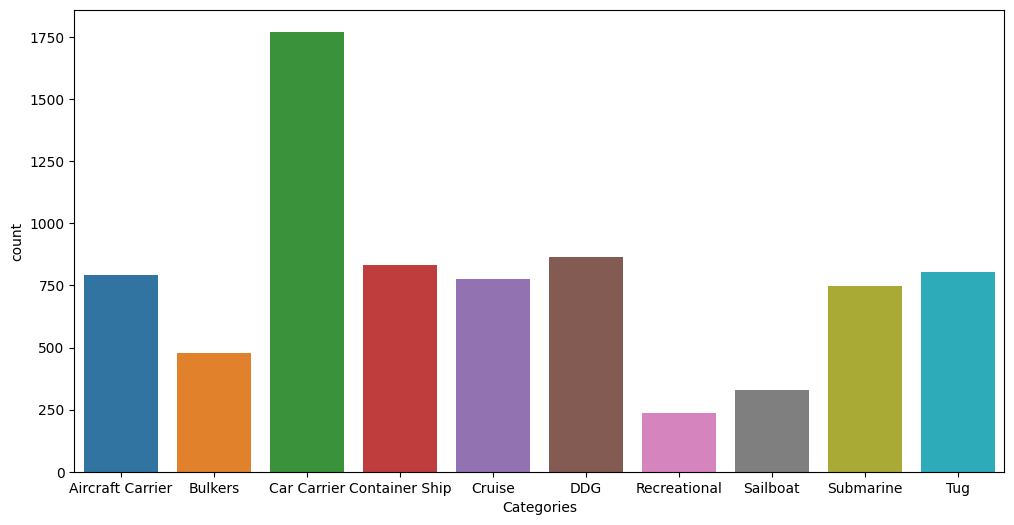

In [ ]:
#Let's look at the class balance on the training images using a seaborn countplot.

path = 'put here the train folder path'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
classes=[]
for folder, subfolders, filenames in os.walk(path):
  classes.append(subfolders)
  classes=classes[0]
  break
categorias=[]
for name in img_names:
  for classe in classes:
    if classe in name:
      categorias.append(classe)
plt.figure(figsize=[12,6])
sns.countplot(data=pd.DataFrame(categorias, columns=["Categories"]), x="Categories")

In [ ]:
#Let's now take a look at the relative frequence of each class.
pd.DataFrame(categorias, columns=["Categories"]).value_counts(normalize=True)

Categories      
Car Carrier         0.232272
DDG                 0.113121
Container Ship      0.109058
Tug                 0.105256
Aircraft Carrier    0.103814
Cruise              0.101979
Submarine           0.097785
Bulkers             0.062787
Sailboat            0.042994
Recreational        0.030935
dtype: float64

As we can see, we have unbalanced data. The class "Car Carrier" is responsible for more than 23% of the data, while the class "Recreational" is responsible for only 3% of the data.

In [ ]:
#Looking at the image sizes, we can see that 97% (7.406/7.629) are 600x416.
img_sizes = []
for item in img_names:
   with Image.open(item) as img:
    img_sizes.append(img.size)
data_img=pd.DataFrame(img_sizes)
data_img["size"]=data_img[0].astype(str)+"x"+data_img[1].astype(str)
data_img["size"].value_counts()

600x416      7406
640x400        15
1200x675        6
800x600         5
1920x1080       4
             ... 
800x532         1
800x599         1
330x153         1
298x169         1
1600x803        1
Name: size, Length: 168, dtype: int64

## Data Preprocessing

In the next cell we will build a transformer, that will apply some transformations on the images, as shown below:

- Data augmentation - It preserves the label and apply the transformations on the images we already have (Warping). We'll use  RandomRotation, RandomHorizontalFlip and CenterCrop in order to prevent overfitting. With the exception of CenterCrop, we will only use data augmentation in training images, so we'll avoid data leak.
- Resize and Normalization - As we'll use a pre-trained model, that is AlexNet, the input images needs to be normalized in the same way. Considering mini-batches of 3-channel RGB images of shape (3 x H x W), H and W are expected to be at least 224. The images have to be normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Within the transformer we also have a tensor transformation.


In [ ]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In the next cell, first we are going to create a train image folder and a test image folder. The test one contains the images of the "test" folder and the "valid" folder. The train image folder contains 7.629 images and the test image folder contains 1.070 images.

Then, we'll wrap it with a DataLoader, dividing the images in batches of 10 images. This gives us a powerful sampler that provides single- or multi-process iterators over the dataset.





In [ ]:
root = 'put here the ships_dataset folder path'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)
valid_data = datasets.ImageFolder(os.path.join(root, 'valid'), transform=test_transform)
test_data=ConcatDataset([test_data, valid_data])

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)


class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Aircraft Carrier', 'Bulkers', 'Car Carrier', 'Container Ship', 'Cruise', 'DDG', 'Recreational', 'Sailboat', 'Submarine', 'Tug']
Training images available: 7629
Testing images available:  1070


Label: [    2     1     2     0     3     0     2     2     9     2]
Class:  Car Carrier Bulkers Car Carrier Aircraft Carrier Container Ship Aircraft Carrier Car Carrier Car Carrier Tug Car Carrier


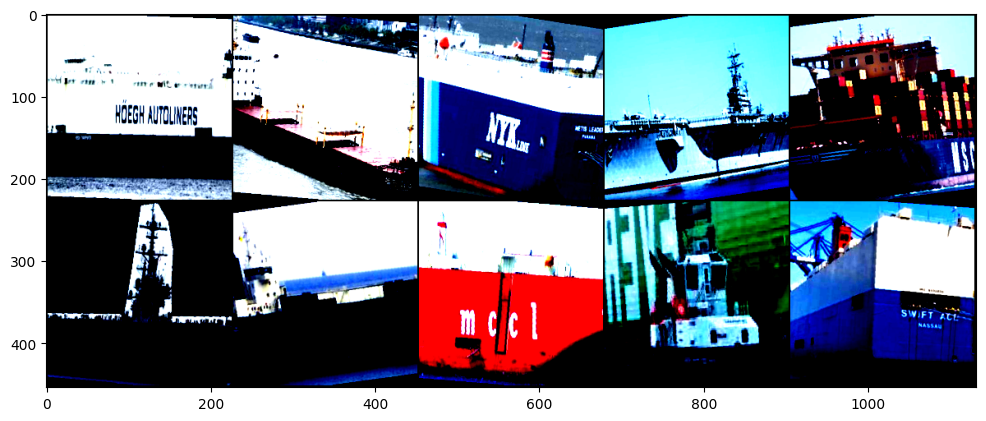

In [ ]:
#Showing a batch of images.


np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(12,8))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Creating the model


Now, let's instantiate our pre-trained model, AlexNet.

We are setting "pretrained" to True, so we'll use the parameters that were already trained in AlexNet. As we are going to see later, we are going to update the weights and biases only for the dense layers. The parameters of the convolutional layers will remain the same.

In [ ]:

AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 243MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#We want to freeze the pre-trained weights and biases. We set requires_grad to False so we don't backprop through them.
for param in AlexNetmodel.parameters():
    param.requires_grad = False

Next, we need to modify the fully connected layers to produce a 10 neurons output, instead of the 1000 output in the original AlexNet model, as shown above. The fully connected section is labeled "classifier" in the AlexNet model.
Note that when we assign new layers, their parameters default
 change to requires_grad=True.

We also add a final activation function, that is softmax, once this is a multi-class problem.

In [ ]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(9216, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 4096),
                                        nn.ReLU(),
                                        nn.Linear(4096, 10),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#Setting the Loss Function and Optimizer. We are going to use the CrossEntropyLoss as a loss function, as our problem is a classification one and ADAM as the optimizer. The learning rate will be 0.001.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

## Training the model

Let's train our model and estimate the parameters using backpropagation. We will compute the training and validation losses.

We will use 3 epochs and show the results from 200 to 200 batches for each epoch for the training set.

In the training, we will only update the weights and biases of the dense layers, since the weights and biases of the convolutional layers won't change.

In [ ]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/7629]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        AlexNetmodel.eval()
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model

            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()



    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    AlexNetmodel.train()

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/7629]  loss: 0.10987576  accuracy:  72.700%
epoch:  0  batch:  400 [  4000/7629]  loss: 0.03879564  accuracy:  78.375%
epoch:  0  batch:  600 [  6000/7629]  loss: 0.38586608  accuracy:  81.050%
epoch:  1  batch:  200 [  2000/7629]  loss: 0.65577328  accuracy:  88.450%
epoch:  1  batch:  400 [  4000/7629]  loss: 0.66505426  accuracy:  88.875%
epoch:  1  batch:  600 [  6000/7629]  loss: 0.14434624  accuracy:  89.133%
epoch:  2  batch:  200 [  2000/7629]  loss: 0.23816590  accuracy:  90.550%
epoch:  2  batch:  400 [  4000/7629]  loss: 0.27887413  accuracy:  90.975%
epoch:  2  batch:  600 [  6000/7629]  loss: 0.00009788  accuracy:  90.917%

Duration: 2258 seconds


In [ ]:
#Saving the model.
torch.save(AlexNetmodel.state_dict(), 'AlexNetmodel.pt')

## Validating the model

In this section we'll validate our model using accuracy, confusion matrix, and classification report. This last one will inform us the precision, recall and f1-score for each class.

In [ ]:
#After the 3 epochs, our model classified corectly 995 images of the 1.070, that is 92,99% of acurracy.
tst_corr.item(),tst_corr.item()/1070

(995, 0.9299065420560748)

In [ ]:
#Let's get all the predictions at once using only one batch, so we can use later canfusion matrix and classification report in order to continue validating our model.
test_loader = DataLoader(test_data, batch_size=1070, shuffle=True)
with torch.no_grad():
    AlexNetmodel.eval()
    for b, (X_test, y_test) in enumerate(test_loader):
       # Apply the model

        y_val = AlexNetmodel(X_test)

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1]


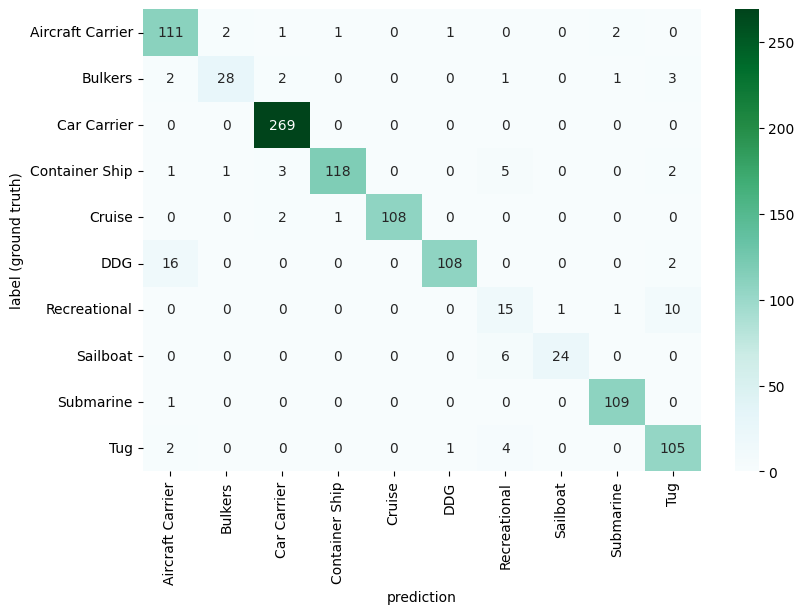

In [ ]:
# Display the confusion matrix as a heatmap.
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [ ]:
#Display the classification_report.
print(classification_report(y_test.view(-1), predicted.view(-1),target_names=class_names))


                  precision    recall  f1-score   support

Aircraft Carrier       0.83      0.94      0.88       118
         Bulkers       0.90      0.76      0.82        37
     Car Carrier       0.97      1.00      0.99       269
  Container Ship       0.98      0.91      0.94       130
          Cruise       1.00      0.97      0.99       111
             DDG       0.98      0.86      0.92       126
    Recreational       0.48      0.56      0.52        27
        Sailboat       0.96      0.80      0.87        30
       Submarine       0.96      0.99      0.98       110
             Tug       0.86      0.94      0.90       112

        accuracy                           0.93      1070
       macro avg       0.89      0.87      0.88      1070
    weighted avg       0.93      0.93      0.93      1070



# Conclusion

The project was successfull in what it proposed. Using the AlexNet CNN built with pytorch, we got an accuracy for the validation dataset about 92,99% after only 3 epochs of training. As we used a pre-trained model, we didn't update the parameters of the convolutional layers, but only the ones in the dense layers, reason why only 3 epochs of training was enough.

In spite of the high accuracy of the whole set, we can have some insights looking at the confusion matrix and classification_report above. For instance, we can tell the class that our model made more mistakes, that is "Recreational", that from 27 images, our algorithm predicted 10 of them as being a "Tug". The class "Recreational" has a precision of 0,48, recall of 0,56 and f1-score of 0,52. All the other classes have excellent metrics, most of them higher than 90%.

As it was found in the beginning of the notebook, "Recreational" is the class that has the lower relative frequency, only 3%. It must be the reason for the poor results and, in order to improve it's metrics, one could use some techniques, for instance, oversampling using data augmentation, using Generative Adversarial Networks, in order to generate new data, among others.

In addition to solving the specific problem, to presenting several concepts in deep learning, the CNN used in this notebook can be reproducible for different kinds of image classification problems.